In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
        print('Found GPU at: {}'.format(device_name))

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, BatchNormalization, GlobalAveragePooling1D
from keras.optimizers import Adam, Adadelta

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Found GPU at: /device:GPU:0
env: PYTHONHASHSEED=0


# Keras Neural Networks for Weather Time Series Nowcasts

Building neural networks with [keras](https://keras.io/) for time series analysis of Cambridge UK weather data.


## Import Data

Data has been cleaned but may still have issues.  See the 
[cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning)
in the 
[Cambridge Temperature Model](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
repository for details.

The `y` variable is temperature * 10.  I'm primarily interested in short term temperature forecasts (less than 2 hours) but forecasts over 24 hours are also interesting.

In [3]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/data/CamUKWeather.csv?raw=true"
else:
    data_loc = "../data/CamUKWeather.csv"
df = pd.read_csv(data_loc, parse_dates = True)
print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
df

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ds                 192885 non-null  object
 1   year               192885 non-null  int64 
 2   doy                192885 non-null  int64 
 3   time               192885 non-null  object
 4   y                  192885 non-null  int64 
 5   humidity           192885 non-null  int64 
 6   dew.point          192885 non-null  int64 
 7   pressure           192885 non-null  int64 
 8   wind.speed.mean    192885 non-null  int64 
 9   wind.bearing.mean  192885 non-null  int64 
 10  wind.speed.max     192885 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80


---

## Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:
 * Wind direction and speed transformation
 * Time conversion
 * Split data
 * Normalise data
 * Window data

### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is categorised at 45 degree increments, 
i.e. 0, 45, 90, 135, 180, 225, 270, 315.  Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

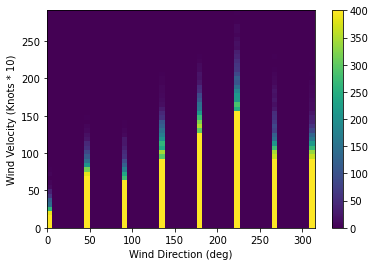

In [4]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (Knots * 10)');

Convert wind direction and speed to _x_ and _y_ vectors, so the model can more easily interpret them.

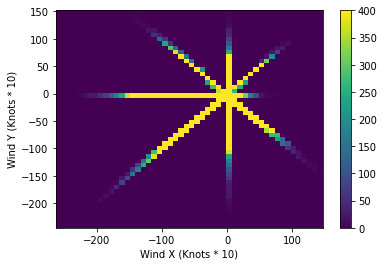

In [5]:
wv = df['wind.speed.mean']
max_wv = df['wind.speed.max']

# Convert to radians.
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components.
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max.wind.x'] = max_wv * np.cos(wd_rad)
df['max.wind.y'] = max_wv * np.sin(wd_rad)

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)');

Better, but not ideal.  Some data augmentation with a method like 
[mixup](https://arxiv.org/abs/1710.09412) may be beneficial.


### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

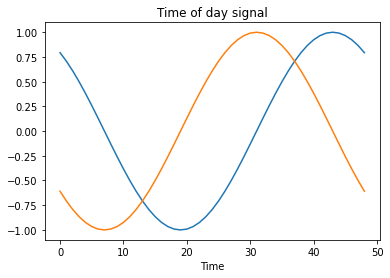

In [6]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.title('Time of day signal');

# plt.plot(np.array(df['year.sin'])[:17532])
# plt.plot(np.array(df['year.cos'])[:17532])
# plt.xlabel('Time')
# plt.title('Time of year signal');

### Split data

Use a (70%, 20%, 10%) split for the training, validation, and test sets.

In [7]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure',
             'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y', 
             'day.sin', 'day.cos', 'year.sin', 'year.cos']
del_cols = ['ds', 'year', 'doy', 'time', 
            'wind.bearing.mean', 'wind.speed.mean', 'wind.speed.max']
df_orig  = df
df.drop(del_cols, axis = 1, inplace = True)

n = len(df)
train_df = df[0:int(n * 0.7)]
valid_df = df[int(n * 0.7):int(n * 0.9)]
test_df  = df[int(n * 0.9):]

print("train shape: ", train_df.shape)
print("valid shape: ", valid_df.shape)
print("test shape:  ",  test_df.shape)

train shape:  (135019, 12)
valid shape:  (38577, 12)
test shape:   (19289, 12)


### Normalise data

Features should be scaled before neural network training.  Arguably, scaling should be done using moving averages to avoid accessing future values.  
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) 
normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) 
to see distribution of features.

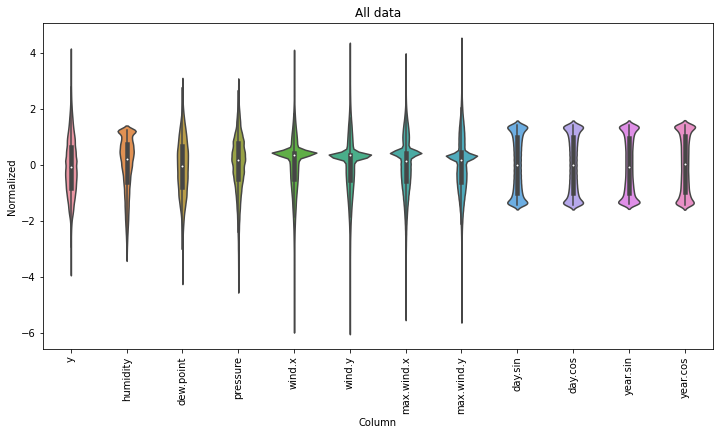

In [8]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 90)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.


### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing)
function:
 * sequence_length: 
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride: 
   * Period between successive output sequences.  For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size: 
   * Number of samples in each batch
 * shuffle: 
   * Shuffle output samples, or use chronological order
 
Initial values used:
 * sequence_length (aka lags): 4
 * steps ahead (what to forecast): 1 and separately 4
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True
 
The lags, batch_size and shuffle values may be optimised later.

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead.  Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

First, check results are as expected for single batch with `shuffle = False`.
Then, process all training data with `shuffle = True`.

In [14]:
def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    data_np = np.array(data, dtype = np.float32)    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
           data    = data_np,
           targets = None,
           sequence_length = total_window_size,
           sequence_stride = 1,
           shuffle    = shuffle,
           batch_size = bs)
            
    col_indices = {name: i for i, name in enumerate(data.columns)}    
    X_slice = slice(0, lags)
    y_start = total_window_size - steps_ahead
    y_slice = slice(y_start, None)

    
    def split_window(features):   
        X = features[:, X_slice, :]
        y = features[:, y_slice, :]
        X = tf.stack(
            [X[:, :, col_indices[name]] for name in data.columns if name not in y_cols],
            axis = -1)    
        y = tf.stack(
            [y[:, :, col_indices[name]] for name in y_cols],
            axis = -1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually.  This way the `tf.data.Datasets` are easier to inspect.
        X.set_shape([None, lags,        None])
        y.set_shape([None, steps_ahead, None])

        return X, y

    
    ds = ds.map(split_window)
        
    return ds


def make_datasets(train, valid, test, 
                  y_cols = 'y', lags = 1, steps_ahead = 1, 
                  stride = 1, bs = 32, shuffle = False):
    ds_train = make_dataset(train, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_valid = make_dataset(valid, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_test  = make_dataset(test,  y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):
    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0]) 
    
    return 1


# Single step-ahead
lags = 4
ds_train_4l_1s, ds_valid_4l_1s, ds_test_4l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = lags, shuffle = True, bs = 16)
dataset_sanity_checks(ds_train_4l_1s, '1s train');

# 4 steps-ahead
steps = stride = 4
ds_train_4l_4s, ds_valid_4l_4s, ds_test_4l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = lags, steps_ahead = steps, 
                                                              stride = stride)
display(train_df.head(lags + steps))
dataset_sanity_checks(ds_train_4l_4s, '4s train');

lags = 1
ds_train_1l_1s, ds_valid_1l_1s, ds_test_1l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = lags, shuffle = True, bs = 16)
steps = stride = 4
ds_train_1l_4s, ds_valid_1l_4s, ds_test_1l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = lags, steps_ahead = steps, 
                                                              stride = stride, shuffle = True, bs = 16)

1s train batches:  4220
	X (batch_size, time, features):  (32, 4, 11)
	y (batch_size, time, features):  (32, 1, 1)
	X[0][0]:  tf.Tensor(
[[ 0.81596315 -0.01348285  0.5135336   0.29993978  0.19869295  0.14826173
   0.01161141  1.2256845   0.7081165  -1.3817555  -0.1598449 ]
 [ 0.9355468  -0.03303898  0.42764908  0.434478    0.34234142  0.2951075
   0.162846    1.3074644   0.5421291  -1.381813   -0.15933792]
 [ 0.9953387   0.00607328  0.5135336   0.38402617  0.28847325  0.2951075
   0.162846    1.366899    0.36687738 -1.3818705  -0.1588309 ]
 [ 0.9355468  -0.1112635   0.5135336   0.434478    0.34234142  0.2951075
   0.162846    1.4029715   0.18536    -1.3819277  -0.15832385]], shape=(4, 11), dtype=float32)
	y[0][0]:  tf.Tensor([[-0.6279126]], shape=(1, 1), dtype=float32)


,y,humidity,dew.point,pressure,wind.x,wind.y,max.wind.x,max.wind.y,day.sin,day.cos,year.sin,year.cos
0,1.268343,-0.619041,1.218553,-0.345311,-2.490859,0.342341,-2.465445,0.314081,1.122959,-0.860634,-0.690332,-1.228850
1,1.346058,-0.559249,1.355446,-0.345311,-2.823824,0.342341,-2.257773,0.314081,1.001045,-0.999780,-0.690768,-1.228594
2,1.408231,-0.678833,1.335890,-0.345311,-2.728691,0.342341,-2.257773,0.314081,0.862029,-1.121807,-0.691203,-1.228338
3,1.485946,-0.678833,1.433671,-0.345311,-2.633558,0.342341,-2.050102,0.314081,0.708289,-1.224628,-0.691639,-1.228082
4,1.688006,-1.097376,1.355446,-0.345311,-3.014090,0.342341,-2.257773,0.314081,0.542456,-1.306484,-0.692074,-1.227826
5,1.688006,-1.216959,1.257666,-0.259427,-2.942740,0.342341,-2.465445,0.314081,0.367367,-1.365974,-0.692509,-1.227569
6,1.625834,-1.216959,1.179441,-0.345311,-1.835855,-2.081727,-1.613888,-1.803204,0.186018,-1.402080,-0.692944,-1.227312
7,1.750178,-1.097376,1.414115,-0.345311,-2.086544,0.342341,-1.634760,0.314081,0.001513,-1.414185,-0.693379,-1.227056


4s train batches:  4220
	X (batch_size, time, features):  (32, 4, 11)
	y (batch_size, time, features):  (32, 4, 1)
	X[0][0]:  tf.Tensor(
[[-0.61904097  1.2185533  -0.3453114  -2.4908588   0.34234142 -2.4654448
   0.31408057  1.1229588  -0.860634   -0.6903321  -1.2288499 ]
 [-0.55924916  1.3554462  -0.3453114  -2.823824    0.34234142 -2.2577734
   0.31408057  1.0010449  -0.9997797  -0.6907677  -1.2285941 ]
 [-0.6788328   1.33589    -0.3453114  -2.728691    0.34234142 -2.2577734
   0.31408057  0.86202854 -1.1218071  -0.69120324 -1.228338  ]
 [-0.6788328   1.4336708  -0.3453114  -2.6335583   0.34234142 -2.0501022
   0.31408057  0.7082886  -1.2246284  -0.69163865 -1.2280818 ]], shape=(4, 11), dtype=float32)
	y[0][0]:  tf.Tensor(
[[1.6880062]
 [1.6880062]
 [1.6258337]
 [1.7501785]], shape=(4, 1), dtype=float32)


---


## Model Building

First, I compare unoptimised model architectures.  Then I optimise the best performing architecture.

Model architectures considered:
 * MLP
 * [FCN](https://arxiv.org/abs/1611.06455)
 * ResNet
 
The architectures considered were inspired by those used by Wang *et al* in 
[Time Series Classification from Scratch with Deep
Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).
Hyperparameter settings from 
[Deep learning for time series classification: a review](https://link.springer.com/article/10.1007%2Fs10618-019-00619-1) were used.

I'm primarily interested in "now-casting" or forecasting in the next 1 or 2 hours.
The following model outputs are investigated:
 * Single step ahead - 30 mins
 * Multi-step ahead - 30, 60, 90 and 120 mins

The training and validation code are stored in the `compile_fit_validate` function below.


### Multi-layer perceptron

...

Architecture details

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_40 (Dropout)         (None, 1, 11)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 1, 500)            6000      
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 500)            0         
_________________________________________________________________
dense_44 (Dense)             (None, 1, 500)            250500    
_________________________________________________________________
dropout_42 (Dropout)         (None, 1, 500)            0         
_________________________________________________________________
dense_45 (Dense)             (None, 1, 500)            250500    
_________________________________________________________________
dropout_43 (Dropout)         (None, 1, 500)            0       

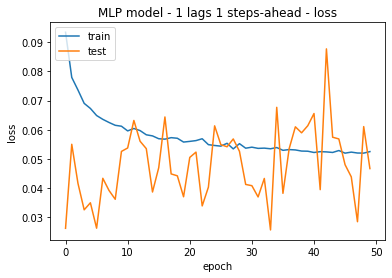

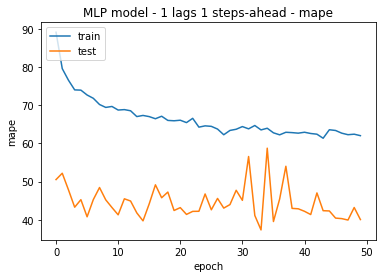

MLP model - 1 lags 1 steps-ahead - train min loss: 0.051995	mae: 0.143097	mape: 63.392769	epoch: 46
MLP model - 1 lags 1 steps-ahead - valid min loss: 0.025678	mae: 0.124415	mape: 37.361343	epoch: 34



In [25]:
def compile_fit_validate(model, train, valid, optimizer, epochs = 5, verbose = 1):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if optimizer.lower() == 'adadelta':
        opt = Adadelta(lr = 1.0)
    else:
        opt = Adam(lr = 0.001)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape'])    
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose)
    
    return h

    
def plot_history(h, name):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper left')
    plt.show()

    plt.plot(h.history['mape'])
    plt.plot(h.history['val_mape'])
    plt.title(name + ' mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper left')
    plt.show();

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


# For testing compile_fit_validate, plot_progress etc
def build_small_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    small = Sequential(name = name)
    
    small.add(Input(shape = in_shape))
    
    small.add(Dense(64, activation = 'relu'))
    small.add(Dense(64, activation = 'relu'))
    
    small.add(Dense(1))
    
    return small


def build_mlp_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Dropout(0.1))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.3))
    
    mlp.add(Dense(1))
    
    return mlp


def run_model(model, train, valid, optimizer = 'adam', epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, optimizer, epochs)
    plot_history(h, model_id)
    print_min_loss(h, model_id)
    
    return h
    

# For testing purposes
# name = 'small'
# small_4l_1s = build_small_model(name, ds_train_4l_1s)
# run_model(small_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 2)
# small_4l_4s = build_small_model(name, ds_train_4l_4s)
# run_model(small_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 2)


name = 'MLP'
mlp_1l_1s   = build_mlp_model(name, ds_train_1l_1s)
h_mlp_1l_1s = run_model(mlp_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, optimizer = 'adadelta', epochs = 50)

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_40 (Dropout)         (None, 1, 11)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 1, 500)            6000      
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 500)            0         
_________________________________________________________________
dense_44 (Dense)             (None, 1, 500)            250500    
_________________________________________________________________
dropout_42 (Dropout)         (None, 1, 500)            0         
_________________________________________________________________
dense_45 (Dense)             (None, 1, 500)            250500    
_________________________________________________________________
dropout_43 (Dropout)         (None, 1, 500)            0       

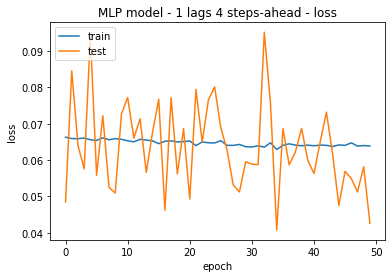

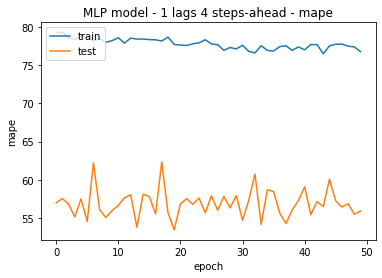

MLP model - 1 lags 4 steps-ahead - train min loss: 0.062902	mae: 0.169730	mape: 76.957886	epoch: 35
MLP model - 1 lags 4 steps-ahead - valid min loss: 0.040764	mae: 0.155673	mape: 58.679005	epoch: 35



In [29]:
# mlp_4l_4s   = build_mlp_model(name, ds_train_4l_4s)
# h_mlp_4l_4s = run_model(mlp_4l_1s, ds_train_4l_4s, ds_valid_4l_4s, optimizer = 'adadelta', epochs = 50)

mlp_1l_4s   = build_mlp_model(name, ds_train_1l_4s)
h_mlp_1l_4s = run_model(mlp_1l_1s, ds_train_1l_4s, ds_valid_1l_4s, optimizer = 'adadelta', epochs = 50)

### Fully convolutional network

See [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455)
for a detailed description of the Fully Convolutional Network (FCN) architecture.

The FCN architecture is a variant of the Convolutional Neural Network (CNN).  A Convolutional 
Neural Network (CNN) usually contains fully-connected layers or a MLP at the 
end of the network.  The FCN does not include these final layers, so it is learning 
convolutional filters everywhere.

**TODO** Include figure comparing FCNs and CNNs

Architecture details

...

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 128)            11392     
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 128)            512       
_________________________________________________________________
activation_9 (Activation)    (None, 1, 128)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 256)            164096    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 256)            1024      
_________________________________________________________________
activation_10 (Activation)   (None, 1, 256)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 128)            98432   

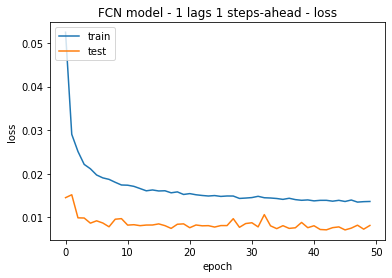

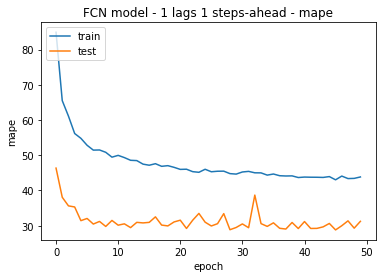

FCN model - 1 lags 1 steps-ahead - train min loss: 0.013500	mae: 0.088315	mape: 43.379349	epoch: 48
FCN model - 1 lags 1 steps-ahead - valid min loss: 0.007117	mae: 0.059371	mape: 28.798401	epoch: 46



In [26]:
def build_fcn_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = 128, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(1))

    return fcn


name = 'FCN'
# fcn_4l_1s   = build_fcn_model(name, ds_train_4l_1s)
# h_fcn_4l_1s = run_model(fcn_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 50)

fcn_1l_1s   = build_fcn_model(name, ds_train_1l_1s)
h_fcn_1l_1s = run_model(fcn_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, epochs = 50)

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1, 128)            11392     
_________________________________________________________________
batch_normalization_12 (Batc (None, 1, 128)            512       
_________________________________________________________________
activation_12 (Activation)   (None, 1, 128)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 256)            164096    
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 256)            1024      
_________________________________________________________________
activation_13 (Activation)   (None, 1, 256)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 128)            98432   

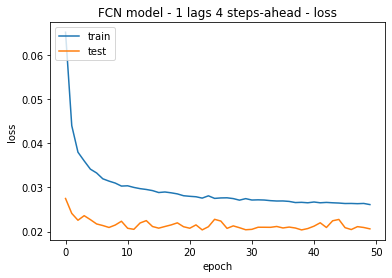

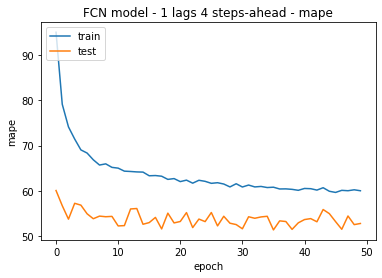

FCN model - 1 lags 4 steps-ahead - train min loss: 0.026128	mae: 0.121106	mape: 59.991417	epoch: 50
FCN model - 1 lags 4 steps-ahead - valid min loss: 0.020389	mae: 0.103281	mape: 51.446545	epoch: 39



In [28]:
# fcn_4l_4s   = build_fcn_model(name, ds_train_4l_4s)
# h_fcn_4l_4s = run_model(fcn_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 50)

ds_train_1l_4s, ds_valid_1l_4s, ds_test_1l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 1, steps_ahead = 4, stride = 4, shuffle = True, bs = 16)

fcn_1l_4s   = build_fcn_model(name, ds_train_1l_4s)
h_fcn_1l_4s = run_model(fcn_1l_4s, ds_train_1l_4s, ds_valid_1l_4s, epochs = 50)

### Residual network

Residual networks, or ResNets, were originally proposed in
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

Residual neural networks use "identity shortcut connections" to skip over some layers.  Typical ResNet models are implemented with blocks of layer that contain nonlinearities (ReLU) and batch normalization.
Skipping over layers may avoid the problem of vanishing gradients, by reusing activations from a previous layer until the adjacent layer learns its weights.  This should allow training networks with more layers.

**TODO** Include basic ResNet diagram

Architecture details

...

In [ ]:
        n_feature_maps = 64
    
        # BLOCK 1

        conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.BatchNormalization()(output_block_2)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        # FINAL

        gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)


def build_resnet_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    resnet = Sequential(name = name)
    resnet.add(Input(shape = in_shape))
    
    resnet.add(Dense(1))
    
    return resnet
    

name = 'ResNet'
resnet_4l_1s   = build_resnet_model(name, ds_train_4l_1s)
h_resnet_4l_1s = run_model(resnet_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 2)

In [ ]:
resnet_4l_4s   = build_fcn_model(name, ds_train_4l_4s)
h_resnet_4l_4s = run_model(resnet_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 2)

### Architecture comparison and/or optimisation

...

Using `ds_test_1s` and `ds_test_4s`.

Plot residuals of optimised model.

Plot some forecasts?

Optimisation with [keras-tuner](https://github.com/keras-team/keras-tuner)?

...

---


## Conclusion

...

Compare with baselines and/or prophet results?

Future work
 * data augmentation/regularisation with a method like [mixup](https://arxiv.org/abs/1710.09412) may be beneficial for the quantised $x$ and $y$ wind vectors
   * mixup may need to be applied between consecutive observations for time series 
 * consider using 2018 data for validation and 2019 for testing
 * ...

...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/local/opt/python@3.8/bin/python3.8
3.8.6 (default, Oct  8 2020, 14:17:19) 
[Clang 10.0.0 (clang-1000.11.45.5)]

IPython version:
7.19.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
tensorflow,2.4.0
seaborn,0.11.1
pandas,1.0.5
numpy,1.19.5
notebook,6.1.6
matplotlib,3.3.1


In [3]:
!date

Mon Feb  1 12:49:14 GMT 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

In [5]:
from time import sleep

notebook = "keras_mlp_fcn_resnet_time_series_colab.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}

[NbConvertApp] Converting notebook keras_mlp_fcn_resnet_time_series_colab.ipynb to python
[NbConvertApp] Writing 25644 bytes to keras_mlp_fcn_resnet_time_series_colab.py
[NbConvertApp] Converting notebook keras_mlp_fcn_resnet_time_series_colab.ipynb to markdown
[NbConvertApp] Support files will be in keras_mlp_fcn_resnet_time_series_colab_files/
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory keras_mlp_fcn_resnet_time_series_colab_files
[NbConvertApp] Making directory kera